# Actividad 2.3a - Embeddings

## Integrantes:

A01753729 Marco Antonio Caudillo Morales

A01747327 Jorge Daniel Rea Prado

A01753911 Oswaldo Daniel Hernández De Luna

A01754412 Adolfo Sebastian Gonzalez Mora

In [2]:
# %pip install gensim nltk pandas matplotlib scikit-learn 
# %pip install --upgrade numpy gensim


## Propuesta
Utilizar embeddings para la identificación de patrones relacionados con la anorexia porque te permiten capturar el significado contextual y las relaciones semánticas profundas entre palabras, más allá de simples coincidencias léxicas. Esto con el fin de tener en cuenta el contexto de las palabras para dar con el resultado con acertividad según el contexto de las palabras.

Lo que proponemos es ocupar embeddings para darles pesos a las palabras que tengan más relacion con la anorexia y poder identificar a los individuos con estos desordenes alimenticios.

In [3]:
import pandas as pd
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import re
# Esta función limpia el texto eliminando URLs, menciones, signos, números y stopwords, además de convertirlo a minúsculas y tokenizarlo.

def limpiar_tokens(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r"\@\w+|\#|\d+", '', text)
    text = re.sub(r"[^\w\s]", '', text)
    tokens = word_tokenize(text)
    return [word for word in tokens if word not in stopwords.words('spanish') and len(word) > 2]

In [5]:
# Cargar el archivo CSV, seleccionar la columna de texto, aplicar la función de limpieza
df = pd.read_csv('../data/data_train.csv')

text_column = "tweet_text" if "tweet_text" in df.columns else df.columns[0]

df['tokens'] = df[text_column].apply(limpiar_tokens)
df[['tokens']].head()

,tokens
0,"[cheesecake, saludable, azúcar, lactosa, merme..."
1,"[ser, hastaloshuesos]"
2,"[comida, real, clave, sana, delgada, feliz]"
3,"[cambio, hora, bajada, temperaturas, destempla..."
4,"[hace, tiempo, sentía, cuerpo, tan, frío]"


In [6]:
def limpiar_texto(text):
    tokens = limpiar_tokens(text)
    return ' '.join(tokens)

df['texto_limpio'] = df[text_column].apply(limpiar_texto)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=2, max_features=5000)

X = vectorizer.fit_transform(df['texto_limpio'])

In [8]:
df['label'] = df['class'].apply(lambda x: 1 if x == 'anorexia' else 0)

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200], 
    'max_depth': [None, 10, 20], 
    'min_samples_split': [2, 5],     
    'min_samples_leaf': [1, 2],      
    'max_features': ['sqrt', 'log2']   
}

In [10]:
from sklearn.model_selection import train_test_split


grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)




y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [11]:
print("Mejor AUC:", grid_search.best_score_)
print("Mejores hiperparámetros:", grid_search.best_params_)

best_rf = grid_search.best_estimator_

Mejor AUC: 0.936735805573015
Mejores hiperparámetros: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [12]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print("AUC en test:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred, target_names=["Control", "Anorexia"]))

AUC en test: 0.9585842365850396
              precision    recall  f1-score   support

     Control       0.93      0.84      0.88       141
    Anorexia       0.87      0.94      0.91       159

    accuracy                           0.90       300
   macro avg       0.90      0.89      0.90       300
weighted avg       0.90      0.90      0.90       300



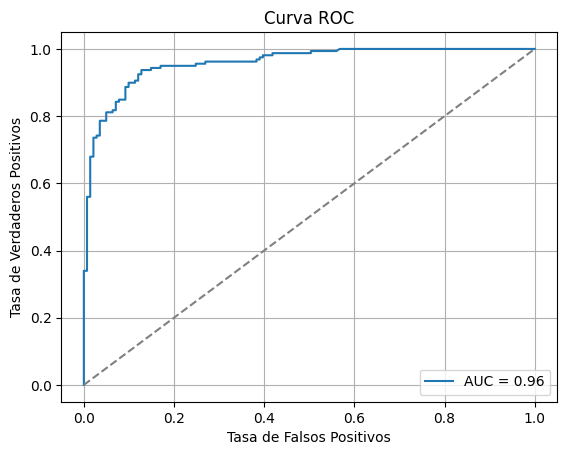

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

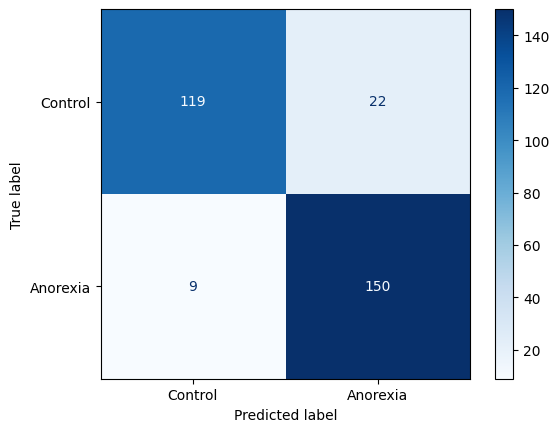

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'Anorexia'])
disp.plot(cmap='Blues')

In [15]:
feature_names = vectorizer.get_feature_names_out()
importancia = best_rf.feature_importances_

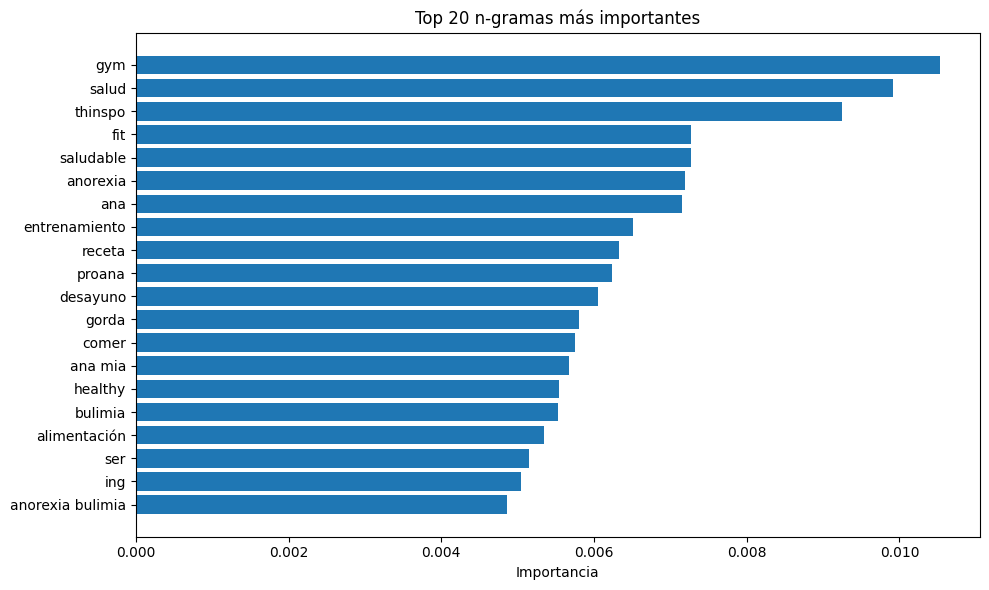

In [16]:
df_importancia = pd.DataFrame({
    'ngrama': feature_names,
    'importancia': importancia
})


df_importancia = df_importancia.sort_values(by='importancia', ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(df_importancia['ngrama'], df_importancia['importancia'])
plt.gca().invert_yaxis()
plt.title("Top 20 n-gramas más importantes")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

In [17]:
import joblib

joblib.dump(best_rf, "../data/models/modelo_anorexia.pkl")
joblib.dump(vectorizer, "../data/models/vectorizador_tfidf.pkl")

['../data/models/vectorizador_tfidf.pkl']

# Validación, Rango de polaridad

In [18]:
df_val = pd.read_csv('../data/data_test_fold2.csv')

In [19]:
df_val['tokens'] = df_val[text_column].apply(limpiar_tokens)

In [20]:
df_val['texto_limpio'] = df_val[text_column].apply(limpiar_texto)

In [21]:
vectorizer = joblib.load('../data/models/vectorizador_tfidf.pkl')

X_val = vectorizer.transform(df_val['texto_limpio'])

In [22]:
clf = joblib.load('../data/models/modelo_anorexia.pkl')

y_pred = clf.predict(X_val)
y_proba = clf.predict_proba(X_val)[:, 1]

In [23]:
df_val['label'] = df_val['class'].apply(lambda x: 1 if x == 'anorexia' else 0)


print(classification_report(df_val['label'], y_pred, target_names=['Control', 'Anorexia']))
print("AUC en validación:", roc_auc_score(df_val['label'], y_proba))

              precision    recall  f1-score   support

     Control       0.88      0.84      0.86       116
    Anorexia       0.87      0.90      0.89       134

    accuracy                           0.88       250
   macro avg       0.88      0.87      0.87       250
weighted avg       0.88      0.88      0.88       250

AUC en validación: 0.9456060216160576


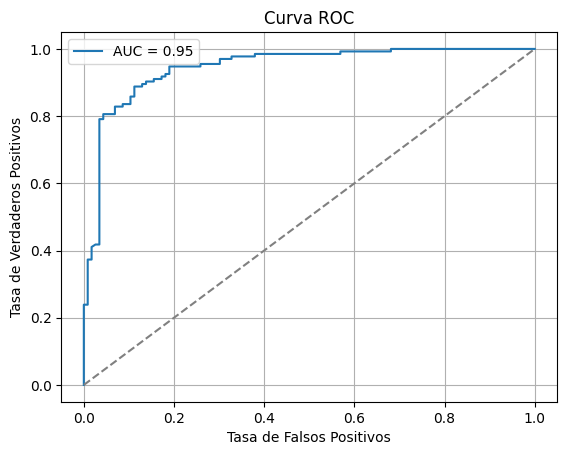

In [24]:
fpr, tpr, thresholds = roc_curve(df_val['label'], y_proba)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(df_val['label'], y_proba):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

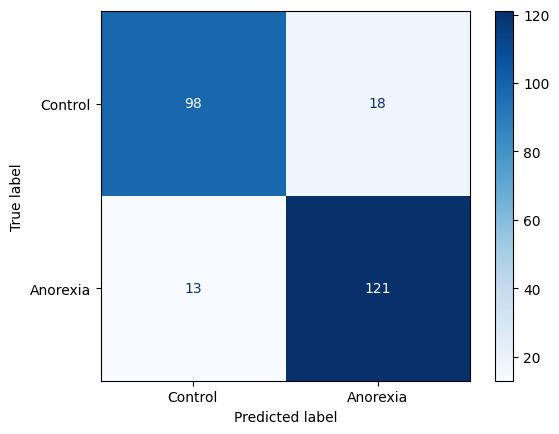

In [ ]:
cm = confusion_matrix(df_val['label'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'Anorexia'])
disp.plot(cmap='Blues')